<a href="https://colab.research.google.com/github/ericburdett/cs601r-dl/blob/master/tl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning for Handwritten Documents

### Imports
Dependencies needed to run the code, including mounting GoogleDrive and copying files.

In [32]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import editdistance as ed
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader
assert torch.cuda.is_available(), "Request a GPU from Runtime > Change Runtime"

# Python
import gc
import os
import gzip
import tarfile
import time

# Data Structures
import pandas as pd
import numpy as np
import json
import csv

# Debug/Progress
from tqdm import tqdm
import pdb
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

# Image Manipulations / Plotting
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import cv2

# Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp "drive/My Drive/datasets/iam.zip" "/content"
!cp "drive/My Drive/datasets/rimes.zip" "/content"
!unzip -q iam.zip -d iam
!unzip -q rimes.zip -d rimes
!wget -q https://raw.githubusercontent.com/ericburdett/cs601r-dl/master/char_set.json
!rm iam.zip
!rm rimes.zip

warning [iam.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [iam.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #95170).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


### Create IAM and RIMES Dataset Classes

In [0]:
class IamDataset(Dataset):
  def __init__(self, desired_size=(32, 128), total_imgs=None):
    self.desired_size = desired_size
    self.img_path = '/content/iam/images/'
    self.df = pd.read_csv('/content/iam/labels.csv', header=None, sep='\t', names=['word', 'seg', 'transcription'], quoting=csv.QUOTE_NONE)
    if total_imgs != None:
      self.df = self.df[:total_imgs]

  def get_df(self):
    return self.df

  def tensor_image(self, path):
    img = Image.open(path + '.png')
    img = self.resize(img)
    # img = img.astype(np.float32)
    x = transforms.functional.to_tensor(img)

    return x

  def resize(self, img):
    img_size = np.array(img).shape

    img_ratio = img_size[0] / img_size[1]
    desired_ratio = self.desired_size[0] / self.desired_size[1]

    if img_ratio >= desired_ratio:
      # Solve by height
      new_height = self.desired_size[0]
      new_width = int(self.desired_size[0] // img_ratio)
    else:
      new_height = int(self.desired_size[1] * img_ratio)
      new_width = self.desired_size[1]
      # Solve by width

    img = np.array(img.resize((new_width, new_height)))

    border_top = self.desired_size[0] - new_height
    border_right = self.desired_size[1] - new_width

    img = np.pad(img, [(border_top, 0), (0, border_right)], mode='constant', constant_values=255)

    return img

  def __getitem__(self, index):
    path = 'iam/images/' + self.df['word'][index]
    img = self.tensor_image(path)

    return img, self.df['transcription'][index]

  def __len__(self):
    return len(self.df)


''' RIMES DATSET '''

class RimesDataset(Dataset):
  def __init__(self, desired_size=(32, 128), total_imgs=None):
    self.desired_size = desired_size
    self.img_path = '/content/rimes/images/'
    self.df = pd.read_csv('/content/rimes/labels.csv', header=None, sep='\t', names=['word', 'transcription'], quoting=csv.QUOTE_NONE)
    if total_imgs != None:
      self.df = self.df[:total_imgs]

  def get_df(self):
    return self.df

  def tensor_image(self, path):
    img = Image.open(path)
    img = self.resize(img)
    # img = img.astype(np.float32)
    x = transforms.functional.to_tensor(img)

    return x

  def resize(self, img):
    img_size = np.array(img).shape

    img_ratio = img_size[0] / img_size[1]
    desired_ratio = self.desired_size[0] / self.desired_size[1]

    if img_ratio >= desired_ratio:
      # Solve by height
      new_height = self.desired_size[0]
      new_width = int(self.desired_size[0] // img_ratio)
    else:
      new_height = int(self.desired_size[1] * img_ratio)
      new_width = self.desired_size[1]
      # Solve by width

    img = np.array(img.resize((new_width, new_height)))

    border_top = self.desired_size[0] - new_height
    border_right = self.desired_size[1] - new_width

    img = np.pad(img, [(border_top, 0), (0, border_right)], mode='constant', constant_values=255)

    return img

  def __getitem__(self, index):
    path = 'rimes/images/' + self.df['word'][index]
    img = self.tensor_image(path)

    return img, self.df['transcription'][index]

  def __len__(self):
    return len(self.df)

Length:  25000
Transcription:  of


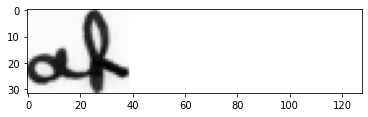

In [34]:
iam = IamDataset(total_imgs=25000)
index = 20

print('Length: ', len(iam))
print('Transcription: ', iam[index][1])
plt.imshow(iam[index][0].squeeze(), cmap='gray')

Length:  25000
Transcription:  elle


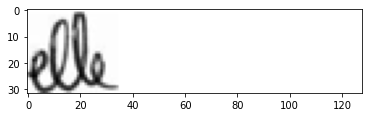

In [35]:
rimes = RimesDataset(total_imgs=25000)
index = 20

print('Length: ', len(rimes))
print('Transcription: ', rimes[index][1])
plt.imshow(rimes[index][0].squeeze(), cmap='gray')

### Character Encoding

In [0]:
class Encoder():
  def __init__(self, sequence_size=150):
    with open('char_set.json') as file:
      self.json = json.load(file)
    
    self.sequence_size = sequence_size

  def remove_duplicates(self, idxs):
    new_idxs = []

    for i in range(len(idxs)):
      if i + 1 == len(idxs) or idxs[i] != idxs[i + 1]:
        new_idxs.append(idxs[i])
    
    return new_idxs
  
  def add_blanks(self, idxs):
    new_idxs = []

    for i in range(len(idxs)):
      new_idxs.append(idxs[i])
      if i + 1 != len(idxs) and idxs[i] == idxs[i + 1]:
        new_idxs.append(0)
    
    return new_idxs
  
  def idx_to_char(self, idx):
    if idx == 0:
      return ''
    else:
      return self.json['idx_to_char'][str(int(idx))]
  
  def char_to_idx(self, char):
    return int(self.json['char_to_idx'][char])
  
  def str_to_idxs(self, string):
    idxs = []

    zeros = np.zeros(self.sequence_size)

    for char in string:
      idxs.append(self.char_to_idx(char))

    # Add blanks if CTC-Loss requires it...
    # idxs = self.add_blanks(idxs)

    idxs = np.concatenate((idxs, zeros))[:self.sequence_size]
    
    return idxs, len(string)

  def idxs_to_str(self, idxs):
    string = ''
    idxs = self.remove_duplicates(idxs)

    for idx in idxs:
      string += self.idx_to_char(idx)
    
    return string
  
  def str_to_idxs_batch(self, batch):
    idxs = []
    lengths = []

    for string in batch:
      idx, length = self.str_to_idxs(string)
      idxs.append(idx)
      if length > self.sequence_size:
        length = self.sequence_size
      lengths.append(length)
    
    return idxs, lengths
  
  def idxs_to_str_batch(self, batch):
    strings = []

    for idxs in batch:
      strings.append(self.idxs_to_str(idxs))
    
    return strings

### Helper Functions

In [0]:
def show_imgs(x, new_fig=True):
    grid = utils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure() # figsize=(50,100)
    plt.imshow(grid.numpy())

def parameter_count(model):
  return sum(p.numel() for p in model.parameters())

def err(prediction, target):
  dist = ed.eval(target, prediction)
  if len(target) == 0:
    return len(prediction)
  
  return float(dist) / float(len(target))

def cer(prediction, target):
  prediction = ' '.join(prediction.split())
  target = ' '.join(target.split())

  return err(prediction, target)

def wer(prediction, target):
  prediction = prediction.split()
  target = target.split()

  return err(prediction, target)

def cer_batch(predictions, targets):
  cers = []

  for prediction, target in zip(predictions, targets):
    cers.append(cer(prediction, target))
  
  return np.mean(cers)

def wer_batch(predictions, targets):
  wers = []

  for prediction, target in zip(predictions, targets):
    wers.append(wer(prediction, target))

  return np.mean(wers)

### Model

In [0]:
class Recognizer(nn.Module):
  def __init__(self, sequence_size=20):
    super(Recognizer, self).__init__()

    self.hidden_size = 256
    self.num_layers = 1
    self.sequence_size = sequence_size

    # Encoder
    self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
    self.tanh1 = nn.Tanh()
    self.conv2 = nn.Conv2d(8, 16, 3, 1, 1) # 4x2
    self.tanh2 = nn.Tanh()
    self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
    self.tanh3 = nn.Tanh()
    self.conv4 = nn.Conv2d(32, 64, 3, 1, 1) # 4x2
    self.tanh4 = nn.Tanh()
    self.conv5 = nn.Conv2d(64, 128, 3, 1, 1)
    self.tanh5 = nn.Tanh()

    self.gate1 = nn.Sequential(nn.Conv2d(16, 16, 3, 1, 1), nn.Sigmoid()) 
    self.gate2 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1), nn.Sigmoid())
    self.gate3 = nn.Sequential(nn.Conv2d(64, 64, 3, 1, 1), nn.Sigmoid())

    # Maxpool
    self.mp = nn.MaxPool2d((32, 1))

    # Decoder
    self.gru1 = nn.GRU(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc1 = nn.Linear(self.hidden_size * 2, 128)
    self.gru2 = nn.GRU(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc2 = nn.Linear(self.hidden_size * 2, self.sequence_size)
    self.softmax = nn.LogSoftmax(dim=1)

  # Input -> (Batch, 1, 128, 256)
  def forward(self, x):
    # Encoder
    out = self.conv1(x)
    out = self.tanh1(out)
    out = self.conv2(out)
    out = self.tanh2(out)

    gate1 = self.gate1(out)
    out = out * gate1

    out = self.conv3(out)
    out = self.tanh3(out)

    gate2 = self.gate2(out)
    out = out * gate2

    out = self.conv4(out)
    out = self.tanh4(out)

    gate3 = self.gate3(out)
    out = out * gate3

    out = self.conv5(out)
    out = self.tanh5(out)

    # Max Pooling across vertical dimension
    out = self.mp(out)

    # Decoder
    out = out.view(-1, 128, 128)

    out, _ = self.gru1(out)
    out = self.fc1(out)
    out, _ = self.gru2(out)
    out = self.fc2(out)
    out = self.softmax(out)

    # Change shape so that we can pass directly to CTC-Loss
    out = out.permute(2, 0, 1)

    return out

In [0]:
class ReverseLayerF(torch.autograd.Function):
  @staticmethod
  def forward(ctx, x, alpha):
    ctx.alpha = alpha
    return x.view_as(x)
  
  @staticmethod
  def backward(ctx, grad_output):
    output = grad_output.neg() * ctx.alpha
    return output, None

In [0]:
class FeatureExtractor(nn.Module):
  def __init__(self):
    super(FeatureExtractor, self).__init__()

    self.conv1 = nn.Sequential(nn.Conv2d(1, 8, 3, 1, 1), nn.Tanh())
    self.conv2 = nn.Sequential(nn.Conv2d(8, 16, 3, 1, 1), nn.Tanh())
    self.conv3 = nn.Sequential(nn.Conv2d(16, 32, 3, 1, 1), nn.Tanh())
    self.conv4 = nn.Sequential(nn.Conv2d(32, 64, 3, 1, 1), nn.Tanh())
    self.conv5 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1), nn.Tanh())    
    self.gate1 = nn.Sequential(nn.Conv2d(16, 16, 3, 1, 1), nn.Sigmoid()) 
    self.gate2 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1), nn.Sigmoid())
    self.gate3 = nn.Sequential(nn.Conv2d(64, 64, 3, 1, 1), nn.Sigmoid())
    self.mp = nn.MaxPool2d((32, 1))
    
  def forward(self, x):
    feat = self.conv1(x)

    feat = self.conv2(feat)
    gate = self.gate1(feat)
    feat = feat * gate

    feat = self.conv3(feat)
    gate = self.gate2(feat)
    feat = feat * gate

    feat = self.conv4(feat)
    gate = self.gate3(feat)
    feat = feat * gate

    feat = self.conv5(feat)
    feat = self.mp(feat)
    feat = feat.view(-1, 128, 128)

    return feat

class Recognizer(nn.Module):
  def __init__(self, sequence_size):
    super(Recognizer, self).__init__()

    self.hidden_size = 256
    self.num_layers = 1
    self.sequence_size = sequence_size

    self.gru1 = nn.GRU(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc1 = nn.Linear(self.hidden_size * 2, 128)
    self.gru2 = nn.GRU(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc2 = nn.Linear(self.hidden_size * 2, self.sequence_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, feat):
    label, _ = self.gru1(feat)
    label = self.fc1(label)
    label, _ = self.gru2(label)
    label = self.fc2(label)
    label = self.softmax(label)
    label = label.permute(2, 0, 1)

    return label

class DomainClassifier(nn.Module):
  def __init__(self):
    super(DomainClassifier, self).__init__()

    self.fc3 = nn.Sequential(nn.Linear(128 * 128, 128), nn.BatchNorm1d(128), nn.ReLU())
    self.fc4 = nn.Sequential(nn.Linear(128, 1), nn.Sigmoid())

  def forward(self, feat, alpha):
    domain = ReverseLayerF.apply(feat, alpha)
    domain = feat.view(-1, 128 * 128)
    domain = self.fc3(domain)
    domain = self.fc4(domain)
    domain = domain.squeeze()

    return domain

In [0]:
class DannRecognizer(nn.Module):
  def __init__(self, sequence_size=20):
    super(DannRecognizer, self).__init__()
    
    self.hidden_size = 256
    self.num_layers = 1
    self.sequence_size = sequence_size

    # Feature Extractor
    self.conv1 = nn.Sequential(nn.Conv2d(1, 8, 3, 1, 1), nn.Tanh())
    self.conv2 = nn.Sequential(nn.Conv2d(8, 16, 3, 1, 1), nn.Tanh())
    self.conv3 = nn.Sequential(nn.Conv2d(16, 32, 3, 1, 1), nn.Tanh())
    self.conv4 = nn.Sequential(nn.Conv2d(32, 64, 3, 1, 1), nn.Tanh())
    self.conv5 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1), nn.Tanh())    
    self.gate1 = nn.Sequential(nn.Conv2d(16, 16, 3, 1, 1), nn.Sigmoid()) 
    self.gate2 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1), nn.Sigmoid())
    self.gate3 = nn.Sequential(nn.Conv2d(64, 64, 3, 1, 1), nn.Sigmoid())
    self.mp = nn.MaxPool2d((32, 1))

    # Label Classifier
    self.gru1 = nn.GRU(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc1 = nn.Linear(self.hidden_size * 2, 128)
    self.gru2 = nn.GRU(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc2 = nn.Linear(self.hidden_size * 2, self.sequence_size)
    self.softmax = nn.LogSoftmax(dim=1)

    # Domain Classifier
    self.fc3 = nn.Sequential(nn.Linear(128 * 128, 128), nn.BatchNorm1d(128), nn.ReLU())
    self.fc4 = nn.Sequential(nn.Linear(128, 1), nn.Sigmoid())

  def forward(self, x, alpha=0.05):
    # Feature Extractor
    feat = self.conv1(x)

    feat = self.conv2(feat)
    gate = self.gate1(feat)
    feat = feat * gate

    feat = self.conv3(feat)
    gate = self.gate2(feat)
    feat = feat * gate

    feat = self.conv4(feat)
    gate = self.gate3(feat)
    feat = feat * gate

    feat = self.conv5(feat)
    feat = self.mp(feat)
    feat = feat.view(-1, 128, 128)

    # Label Classifier
    label, _ = self.gru1(feat)
    label = self.fc1(label)
    label, _ = self.gru2(label)
    label = self.fc2(label)
    label = self.softmax(label)
    label = label.permute(2, 0, 1)

    # Domain Classifier
    domain = ReverseLayerF.apply(feat, alpha)
    domain = feat.view(-1, 128 * 128)
    domain = self.fc3(domain)
    domain = self.fc4(domain)
    domain = domain.squeeze()

    return label, domain

In [41]:
torch.round(torch.tensor([[.45999], [.7898]]))

tensor([[0.],
        [1.]])

In [42]:
rec = DannRecognizer()
print(parameter_count(rec))
label, domain = rec(torch.randn(10, 1, 32, 128))
print('label: ', label.shape)
print('domain: ', domain.shape)
print(domain)

3506117
label:  torch.Size([20, 10, 128])
domain:  torch.Size([10])
tensor([0.6015, 0.5888, 0.5362, 0.5231, 0.5243, 0.4685, 0.4564, 0.5239, 0.5455,
        0.5522], grad_fn=<SqueezeBackward0>)


# Domain Adversarial Transfer

## IAM/Rimes Training Loop

In [0]:
def dann_train(source_train_dataset, source_val_dataset, target_dataset):
  try:
    EPOCHS = 100
    BATCH_SIZE = 100
    ITERATION_SAMPLE = 3000
    SEQUENCE_SIZE = 20

    source_train_loader = DataLoader(source_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    source_val_loader = DataLoader(source_val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    target_loader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

    encoder = Encoder(sequence_size=SEQUENCE_SIZE)
    recognizer = DannRecognizer(sequence_size=SEQUENCE_SIZE).cuda()
    
    optimizer = optim.Adam(recognizer.parameters(), lr=1e-3, weight_decay=1e-4)
    hwr_objective = nn.CTCLoss(blank=0, reduction='none', zero_infinity=True)
    dmn_objective = nn.BCELoss()

    train_src_dmn_loss_epochs, train_tgt_dmn_loss_epochs, train_hwr_loss_epochs, train_cer_epochs, train_wer_epochs = [], [], [], [], []
    src_val_hwr_loss_epochs, src_val_cer_epochs, src_val_wer_epochs = [], [], []
    tgt_hwr_loss_epochs, tgt_cer_epochs, tgt_wer_epochs = [], [], []
    
    for epoch in range(EPOCHS):

      train_src_dmn_losses, train_tgt_dmn_losses, train_hwr_losses, train_cers, train_wers = [], [], [], [], []
      src_val_hwr_losses, src_val_cers, src_val_wers = [], [], []
      tgt_hwr_losses, tgt_cers, tgt_wers = [], [], []

      # Source & Target Training Loop
      recognizer.train()
      train_loop = tqdm(total=len(source_train_loader), position=0, leave=True)
      for batch_num, ((source_imgs, source_words), (target_imgs, target_words)) in enumerate(zip(source_train_loader, target_loader)):
        batch_size = source_imgs.shape[0]
        p = float(batch_num + epoch * len(source_train_loader)) / EPOCHS / len(source_train_loader)
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        # Train with source imgs
        source_idxs, source_word_lengths = encoder.str_to_idxs_batch(source_words)
        source_imgs, hwr_labels = source_imgs.cuda(), torch.tensor(source_idxs).cuda()
        hwr_input_lengths = torch.full((batch_size,), SEQUENCE_SIZE, dtype=torch.long).cuda()
        hwr_target_lengths = torch.tensor(source_word_lengths).cuda()
        src_dmn_labels = torch.ones(batch_size).cuda()

        hwr_preds, src_dmn_preds = recognizer(source_imgs, alpha)

        hwr_loss = hwr_objective(hwr_preds, hwr_labels, hwr_input_lengths, hwr_target_lengths)
        hwr_loss = torch.mean(hwr_loss)
        src_dmn_loss = dmn_objective(src_dmn_preds, src_dmn_labels)

        preds_strings = encoder.idxs_to_str_batch(hwr_preds.permute(1, 0, 2).argmax(dim=2).cpu())
        preds_cer = cer_batch(preds_strings, source_words)
        preds_wer = wer_batch(preds_strings, source_words)

        # Train with target imgs
        target_imgs = target_imgs.cuda()
        tgt_dmn_labels = torch.zeros(batch_size).cuda()

        _, tgt_dmn_preds = recognizer(target_imgs, alpha)

        tgt_dmn_loss = dmn_objective(tgt_dmn_preds, tgt_dmn_labels)

        # Keep track of our progress
        train_src_dmn_losses.append(src_dmn_loss.item())
        train_tgt_dmn_losses.append(tgt_dmn_loss.item())
        train_hwr_losses.append(hwr_loss.item())
        train_cers.append(preds_cer)
        train_wers.append(preds_wer)

        train_loop.set_description('Train - Epoch: {}, HWR Loss: {:.4f}, SrcDmn Loss: {:.4f}, TgtDmn Loss: {:.4f}, CER: {:.4f}, WER: {:.4f}, AvgHWR Loss: {:.4f}, AvgSrcDmn Loss: {:.4f}, AvgTgtDmn Loss: {:.4f} AvgCER: {:.4f} AvgWER: {:.4f}'.format(
            epoch, hwr_loss.item(), src_dmn_loss.item(), tgt_dmn_loss.item(), preds_cer, preds_wer, np.mean(train_hwr_losses), np.mean(train_src_dmn_losses), np.mean(train_tgt_dmn_losses), np.mean(train_cers), np.mean(train_wers)
        ))
        train_loop.update(1)

        loss = hwr_loss + src_dmn_loss + tgt_dmn_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      
      train_loop.close()
      gc.collect()

      # Source Validation Loop
      recognizer.eval()
      val_loop = tqdm(total=len(source_val_loader), position=0, leave=True)
      for batch_num, (imgs, words) in enumerate(source_val_loader):
        with torch.no_grad():
          batch_size = imgs.shape[0]

          idxs, word_lengths = encoder.str_to_idxs_batch(words)
          imgs, labels = imgs.cuda(), torch.tensor(idxs).cuda()
          input_lengths = torch.full((batch_size,), SEQUENCE_SIZE, dtype=torch.long).cuda()
          target_lengths = torch.tensor(word_lengths).cuda()

          preds, _ = recognizer(imgs)

          loss = hwr_objective(preds, labels, input_lengths, target_lengths)
          loss = torch.mean(loss)

          preds_strings = encoder.idxs_to_str_batch(preds.permute(1, 0, 2).argmax(dim=2).cpu())
          preds_cer = cer_batch(preds_strings, words)
          preds_wer = wer_batch(preds_strings, words)

          src_val_hwr_losses.append(loss.item())
          src_val_cers.append(preds_cer)
          src_val_wers.append(preds_wer)

          val_loop.set_description('Val   - Epoch: {}, HWR Loss: {:.4f}, CER: {:.4f}, WER: {:.4f}, AvgHWR Loss: {:.4f}, AvgCER: {:.4f}, AvgWER: {:.4f}'.format(
              epoch, loss.item(), preds_cer, preds_wer, np.mean(src_val_hwr_losses), np.mean(src_val_cers), np.mean(src_val_wers)
          ))
          val_loop.update(1)

      val_loop.close()
      gc.collect()

      # Target Test Loop
      test_loop = tqdm(total=len(target_loader), position=0, leave=True)
      for batch_num, (imgs, words) in enumerate(target_loader):
        with torch.no_grad():
          batch_size = imgs.shape[0]

          idxs, word_lengths = encoder.str_to_idxs_batch(words)
          imgs, labels = imgs.cuda(), torch.tensor(idxs).cuda()
          input_lengths = torch.full((batch_size,), SEQUENCE_SIZE, dtype=torch.long).cuda()
          target_lengths = torch.tensor(word_lengths).cuda()

          preds, _ = recognizer(source_imgs)

          loss = hwr_objective(preds, labels, input_lengths, target_lengths)
          loss = torch.mean(loss)

          preds_strings = encoder.idxs_to_str_batch(preds.permute(1, 0, 2).argmax(dim=2).cpu())
          preds_cer = cer_batch(preds_strings, words)
          preds_wer = wer_batch(preds_strings, words)

          tgt_hwr_losses.append(loss.item())
          tgt_cers.append(preds_cer)
          tgt_wers.append(preds_wer)

          test_loop.set_description('Test  - Epoch: {}, HWR Loss: {:.4f}, CER: {:.4f}, WER: {:.4f}, AvgHWR Loss: {:.4f}, AvgCER: {:.4f}, AvgWER: {:.4f}'.format(
              epoch, loss.item(), preds_cer, preds_wer, np.mean(tgt_hwr_losses), np.mean(tgt_cers), np.mean(tgt_wers)
          ))
          test_loop.update(1)
      
      test_loop.close()
      gc.collect()
      
      # Keep track of our progress

      # Train Loop
      train_src_dmn_loss_epochs.append(np.mean(train_src_dmn_losses))
      train_tgt_dmn_loss_epochs.append(np.mean(train_tgt_dmn_losses))
      train_hwr_loss_epochs.append(np.mean(train_hwr_losses))
      train_cer_epochs.append(np.mean(train_cers))
      train_wer_epochs.append(np.mean(train_wers))

      # Validation Loop
      src_val_hwr_loss_epochs.append(np.mean(src_val_hwr_losses))
      src_val_cer_epochs.append(np.mean(src_val_cers))
      src_val_wer_epochs.append(np.mean(src_val_wers))

      # Test Loop
      tgt_hwr_loss_epochs.append(np.mean(tgt_hwr_losses))
      tgt_cer_epochs.append(np.mean(tgt_cers))
      tgt_wer_epochs.append(np.mean(tgt_wers))

  except:
    __ITB__()
    gc.collect()
  finally:
    return recognizer, (train_src_dmn_loss_epochs, train_tgt_dmn_loss_epochs), (train_hwr_loss_epochs, src_val_hwr_loss_epochs, tgt_hwr_loss_epochs), (train_cer_epochs, src_val_cer_epochs, tgt_cer_epochs), (train_wer_epochs, src_val_wer_epochs, tgt_wer_epochs)

## IAM to Rimes

### Training Loop

In [0]:
iam_dataset = IamDataset(desired_size=(32, 128), total_imgs=40000)
rimes_dataset = RimesDataset(desired_size=(32, 128), total_imgs=30000)
iam_train_dataset, iam_val_dataset = torch.utils.data.random_split(iam_dataset, [30000, 10000])

dann_recognizer, dann_domain_losses, dann_label_losses, dann_cer, dann_wer = dann_train(iam_train_dataset, iam_val_dataset, rimes_dataset)

In [62]:
dann_label_losses[1]

[17.0327592086792,
 16.257736263275145,
 16.06429335594177,
 15.578953733444214,
 15.367624254226685,
 14.912204208374023,
 14.670902328491211,
 14.097776203155517,
 13.479649925231934,
 12.804102029800415,
 12.34292260169983,
 11.798559608459472,
 11.572953004837036,
 11.291777715682983,
 10.951611909866333,
 10.72352933883667]

### Results

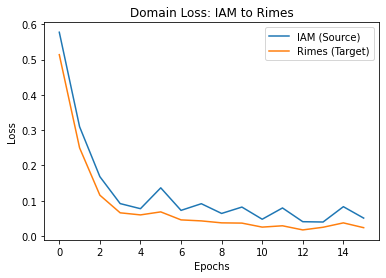

IAM: [0.5772277997434139, 0.3097282366454601, 0.16835998913894096, 0.09213229308525721, 0.07769988962759575, 0.13677395291626454, 0.07292642711506536, 0.09178918256424368, 0.06425295575832327, 0.08229377153950433, 0.04785949922942867, 0.07977806105588874, 0.04088836737520372, 0.039986978398325546, 0.08338852631859481, 0.05107710364507511]
Rimes: [0.5137531127532323, 0.2499189187337955, 0.11590434987097979, 0.06604470452914635, 0.060132403085008265, 0.0686735901578019, 0.04602680903548995, 0.0431497000126789, 0.037610180787742135, 0.03689811148680747, 0.025564993458489577, 0.029305573968837657, 0.017621848594086865, 0.025137516614825776, 0.03755073787256454, 0.02395295489501829]


In [68]:
plt.title('Domain Loss: IAM to Rimes')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(dann_domain_losses[0], label='IAM (Source)')
plt.plot(dann_domain_losses[1], label='Rimes (Target)')
plt.legend()
plt.show()
print('IAM:', dann_domain_losses[0])
print('Rimes:', dann_domain_losses[1])

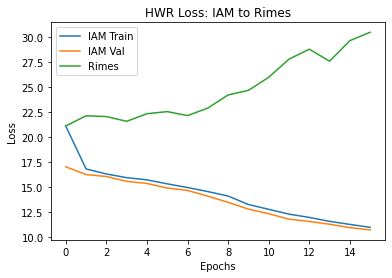

Train: [21.10065129915873, 16.817502654393515, 16.317588637669882, 15.945277309417724, 15.728968931833903, 15.32954753557841, 14.960884698232015, 14.55612219174703, 14.110018278757732, 13.262823047637939, 12.783801708221436, 12.302642704645793, 11.973443190256754, 11.579684940973918, 11.27446161588033, 10.983651116689046]
Val: [17.0327592086792, 16.257736263275145, 16.06429335594177, 15.578953733444214, 15.367624254226685, 14.912204208374023, 14.670902328491211, 14.097776203155517, 13.479649925231934, 12.804102029800415, 12.34292260169983, 11.798559608459472, 11.572953004837036, 11.291777715682983, 10.951611909866333, 10.72352933883667]
Test: [21.11913673400879, 22.13576889038086, 22.055791721343994, 21.58122355779012, 22.339507872263592, 22.550102818806966, 22.15291607538859, 22.90295097351074, 24.21719660441081, 24.675387738545737, 25.981841831207277, 27.796740818023682, 28.787846024831136, 27.592489554087322, 29.644508527119953, 30.48510690053304]


In [69]:
plt.title('HWR Loss: IAM to Rimes')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(dann_label_losses[0], label='IAM Train')
plt.plot(dann_label_losses[1], label='IAM Val')
plt.plot(dann_label_losses[2], label='Rimes')
plt.legend()
plt.show()
print('Train:', dann_label_losses[0])
print('Val:', dann_label_losses[1])
print('Test:', dann_label_losses[2])

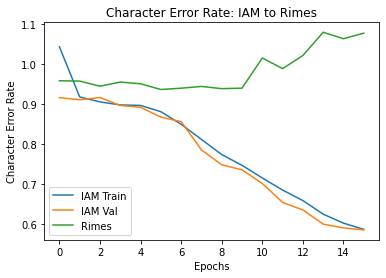

Train: [1.043216873959374, 0.9181875728935093, 0.9058475439409805, 0.8982984413768778, 0.8970630630977496, 0.8813869826830664, 0.8500273936901878, 0.8122653265770178, 0.7744240278465085, 0.7475652485566262, 0.7159962811868501, 0.6858333615003275, 0.6596807643766622, 0.6257600222810671, 0.6033694794905242, 0.5877173726213586]
Val: [0.9164614007848877, 0.9112269563404435, 0.9167739296449166, 0.8968352666412536, 0.8923331135166004, 0.8679118266601819, 0.856698365209352, 0.7860298129794182, 0.7489317841150078, 0.7362947913343966, 0.7023294633801871, 0.6548870651351573, 0.636254880689486, 0.6008855347722453, 0.5914210956879378, 0.5864564100081204]
Test: [0.9585691084140892, 0.9577775001149806, 0.9449212193723031, 0.9553477784477591, 0.9510127997690303, 0.9368035942795307, 0.9400716167064502, 0.9444284030118202, 0.9389175652914624, 0.9401694053428226, 1.0155189333420565, 0.9888518644713845, 1.0216286084953345, 1.0796306443026644, 1.0634341744591551, 1.0773274077278643]


In [70]:
plt.title('Character Error Rate: IAM to Rimes')
plt.xlabel('Epochs')
plt.ylabel('Character Error Rate')
plt.plot(dann_cer[0], label='IAM Train')
plt.plot(dann_cer[1], label='IAM Val')
plt.plot(dann_cer[2], label='Rimes')
plt.legend()
plt.show()
print('Train:', dann_cer[0])
print('Val:', dann_cer[1])
print('Test:', dann_cer[2])

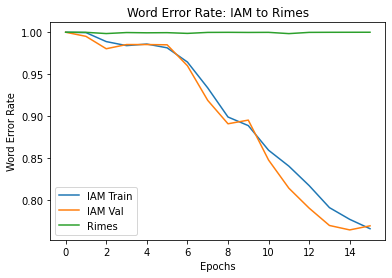

Train: [1.0, 0.9995666666666667, 0.9888333333333335, 0.9840333333333334, 0.9858999999999999, 0.9813999999999998, 0.9644333333333333, 0.9336, 0.8987999999999999, 0.8885333333333332, 0.8591333333333334, 0.8401333333333332, 0.8169, 0.7906, 0.7766000000000001, 0.7654333333333333]
Val: [1.0, 0.9951000000000001, 0.9803000000000001, 0.9853000000000001, 0.9853000000000001, 0.985, 0.96, 0.9186999999999999, 0.8907, 0.8951, 0.8474000000000003, 0.8138000000000001, 0.7900000000000001, 0.7693000000000001, 0.764, 0.7689000000000001]
Test: [1.0, 0.9999000000000001, 0.9984333333333334, 0.9996333333333333, 0.9993333333333334, 0.9995, 0.9986333333333335, 0.9998000000000001, 0.9999000000000001, 0.9997666666666669, 0.9998666666666668, 0.9983666666666666, 0.9998333333333335, 0.9999333333333333, 0.9999666666666667, 1.0]


In [71]:
plt.title('Word Error Rate: IAM to Rimes')
plt.xlabel('Epochs')
plt.ylabel('Word Error Rate')
plt.plot(dann_wer[0], label='IAM Train')
plt.plot(dann_wer[1], label='IAM Val')
plt.plot(dann_wer[2], label='Rimes')
plt.legend()
plt.show()
print('Train:', dann_wer[0])
print('Val:', dann_wer[1])
print('Test:', dann_wer[2])

# Baseline Transfer

### IAM/Rimes Training

In [0]:
def train(train_dataset, val_dataset, test_dataset):
  try:
    EPOCHS = 100
    BATCH_SIZE = 250
    ITERATION_SAMPLE = 3000
    SEQUENCE_SIZE = 20

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

    encoder = Encoder(sequence_size=SEQUENCE_SIZE)
    recognizer = Recognizer(sequence_size=SEQUENCE_SIZE).cuda()
    
    optimizer = optim.Adam(recognizer.parameters(), lr=1e-3)

    objective = nn.CTCLoss(blank=0, reduction='none', zero_infinity=True)

    train_losses_epochs = []
    val_losses_epochs = []
    test_losses_epochs = []

    train_cer_epochs = []
    val_cer_epochs = []
    test_cer_epochs = []

    train_wer_epochs = []
    val_wer_epochs = []
    test_wer_epochs = []

    for epoch in range(EPOCHS):
      train_losses = []
      val_losses = []
      test_losses = []

      train_cers = []
      val_cers = []
      test_cers = []

      train_wers = []
      val_wers = []
      test_wers = []

      # Training Loop
      recognizer = recognizer.train()
      train_loop = tqdm(total=len(train_loader), position=0, leave=True)
      for batch_num, (imgs, words) in enumerate(train_loader):
        batch_size = imgs.shape[0]

        idxs, word_lengths = encoder.str_to_idxs_batch(words)

        imgs, labels = imgs.cuda(), torch.tensor(idxs).cuda()

        input_lengths = torch.full((batch_size,), SEQUENCE_SIZE, dtype=torch.long).cuda()
        target_lengths = torch.tensor(word_lengths).cuda()

        preds = recognizer(imgs)

        loss = objective(preds, labels, input_lengths, target_lengths)
        loss = torch.mean(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds_strings = encoder.idxs_to_str_batch(preds.permute(1, 0, 2).argmax(dim=2).cpu())
        preds_cer = cer_batch(preds_strings, words)
        preds_wer = wer_batch(preds_strings, words)

        train_losses.append(loss.item())
        train_cers.append(preds_cer)
        train_wers.append(preds_wer)

        train_loop.set_description('Train - Epoch: {}, Loss: {:.4f}, CER: {:.4f}, WER: {:.4f}, AvgLoss: {:.4f}, AvgCER: {:.4f}, AvgWER: {:.4f}'.format(
            epoch, loss.item(), preds_cer, preds_wer, np.mean(train_losses), np.mean(train_cers), np.mean(train_wers)))
        train_loop.update(1)
      
      train_loop.close()

      # Validation Loop
      recognizer = recognizer.eval()
      val_loop = tqdm(total=len(val_loader), position=0, leave=True)
      for batch_num, (imgs, words) in enumerate(val_loader):
        with torch.no_grad():
          batch_size = imgs.shape[0]

          idxs, word_lengths = encoder.str_to_idxs_batch(words)

          imgs, labels = imgs.cuda(), torch.tensor(idxs).cuda()

          optimizer.zero_grad()

          input_lengths = torch.full((batch_size,), SEQUENCE_SIZE, dtype=torch.long).cuda()
          target_lengths = torch.tensor(word_lengths).cuda()

          preds = recognizer(imgs)

          loss = objective(preds, labels, input_lengths, target_lengths)
          loss = torch.mean(loss)

          preds_strings = encoder.idxs_to_str_batch(preds.permute(1, 0, 2).argmax(dim=2).cpu())
          preds_cer = cer_batch(preds_strings, words)
          preds_wer = wer_batch(preds_strings, words)

          val_losses.append(loss.item())
          val_cers.append(preds_cer)
          val_wers.append(preds_wer)

          val_loop.set_description('Val   - Epoch: {}, Loss: {:.4f}, CER: {:.4f}, WER: {:.4f}, AvgLoss: {:.4f}, AvgCER: {:.4f}, AvgWER: {:.4f}'.format(
              epoch, loss.item(), preds_cer, preds_wer, np.mean(val_losses), np.mean(val_cers), np.mean(val_wers)))
          val_loop.update(1)

      val_loop.close()

      # Test Loop
      recognizer = recognizer.eval()
      test_loop = tqdm(total=len(test_loader), position=0, leave=True)
      for batch_num, (imgs, words) in enumerate(test_loader):
        with torch.no_grad():
          batch_size = imgs.shape[0]

          idxs, word_lengths = encoder.str_to_idxs_batch(words)

          imgs, labels = imgs.cuda(), torch.tensor(idxs).cuda()

          optimizer.zero_grad()

          input_lengths = torch.full((batch_size,), SEQUENCE_SIZE, dtype=torch.long).cuda()
          target_lengths = torch.tensor(word_lengths).cuda()

          preds = recognizer(imgs)

          loss = objective(preds, labels, input_lengths, target_lengths)
          loss = torch.mean(loss)

          preds_strings = encoder.idxs_to_str_batch(preds.permute(1, 0, 2).argmax(dim=2).cpu())
          preds_cer = cer_batch(preds_strings, words)
          preds_wer = wer_batch(preds_strings, words)

          test_losses.append(loss.item())
          test_cers.append(preds_cer)
          test_wers.append(preds_wer)

          test_loop.set_description('Test  - Epoch: {}, Loss: {:.4f}, CER: {:.4f}, WER: {:.4f}, AvgLoss: {:.4f}, AvgCER: {:.4f}, AvgWER: {:.4f}'.format(
              epoch, loss.item(), preds_cer, preds_wer, np.mean(test_losses), np.mean(test_cers), np.mean(test_wers)))
          test_loop.update(1)

      test_loop.close()

      train_losses_epochs.append(np.mean(train_losses))
      val_losses_epochs.append(np.mean(val_losses))
      test_losses_epochs.append(np.mean(test_losses))

      train_cer_epochs.append(np.mean(train_cers))
      val_cer_epochs.append(np.mean(val_cers))
      test_cer_epochs.append(np.mean(test_cers))

      train_wer_epochs.append(np.mean(train_wers))
      val_wer_epochs.append(np.mean(val_wers))
      test_wer_epochs.append(np.mean(test_wers))
  except:
    __ITB__()
    gc.collect()
  finally:
    return recognizer, (train_losses_epochs, val_losses_epochs, test_losses_epochs), (train_cer_epochs, val_cer_epochs, test_cer_epochs), (train_wer_epochs, val_wer_epochs, test_wer_epochs) 

## Train on the IAM Dataset, Test on the Rimes Dataset

### Training Loop

In [0]:
iam_dataset = IamDataset(desired_size=(32, 128), total_imgs=30000)

iam_train_size = int(.8 * len(iam_dataset))
iam_val_size = len(iam_dataset) - iam_train_size

iam_train_dataset, iam_val_dataset = torch.utils.data.random_split(iam_dataset, [iam_train_size, iam_val_size])

rimes_dataset = RimesDataset(desired_size=(32, 128), total_imgs=30000)
iam_to_rimes_recognizer, iam_to_rimes_losses, iam_to_rimes_cers, iam_to_rimes_wers = train(iam_train_dataset, iam_val_dataset, rimes_dataset)

Train - Epoch: 0, Loss: 17.4475, CER: 1.0000, WER: 1.0000, AvgLoss: 26.9922, AvgCER: 1.0402, AvgWER: 1.0104: 100%|██████████| 96/96 [00:30<00:00,  3.10it/s]
Val   - Epoch: 0, Loss: 16.8578, CER: 1.0000, WER: 1.0000, AvgLoss: 17.4199, AvgCER: 1.0000, AvgWER: 1.0000: 100%|██████████| 24/24 [00:05<00:00,  4.56it/s]
Test  - Epoch: 0, Loss: 20.5452, CER: 1.0000, WER: 1.0000, AvgLoss: 20.2920, AvgCER: 1.0000, AvgWER: 1.0000: 100%|██████████| 120/120 [00:23<00:00,  5.02it/s]
Train - Epoch: 1, Loss: 16.8822, CER: 1.0000, WER: 1.0000, AvgLoss: 16.8209, AvgCER: 1.0000, AvgWER: 1.0000: 100%|██████████| 96/96 [00:30<00:00,  3.13it/s]
Val   - Epoch: 1, Loss: 16.9420, CER: 1.0000, WER: 1.0000, AvgLoss: 16.6630, AvgCER: 1.0000, AvgWER: 1.0000: 100%|██████████| 24/24 [00:05<00:00,  4.48it/s]
Test  - Epoch: 1, Loss: 20.4299, CER: 1.0000, WER: 1.0000, AvgLoss: 19.5130, AvgCER: 1.0000, AvgWER: 1.0000: 100%|██████████| 120/120 [00:23<00:00,  5.06it/s]
Train - Epoch: 2, Loss: 17.1211, CER: 1.0000, WER: 1.0

### Results

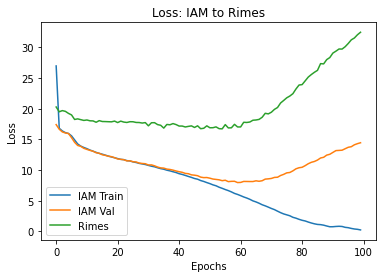

Train: [26.992212732632954, 16.82087700565656, 16.38394159078598, 16.112451473871868, 15.971416562795639, 15.582810908555984, 14.925958583752314, 14.26237565279007, 13.911991228659948, 13.689028759797415, 13.496922234694162, 13.267347753047943, 13.08597598473231, 12.891137013832727, 12.723054299751917, 12.593100845813751, 12.435029019912085, 12.284128030141195, 12.13704518477122, 12.010211169719696, 11.87728359301885, 11.751718997955322, 11.702802528937658, 11.545947869618734, 11.4891208310922, 11.335384756326675, 11.237780461708704, 11.092929343382517, 11.003456979990005, 10.908263276020685, 10.764028042554855, 10.631967653830847, 10.534312884012857, 10.376278032859167, 10.236186236143112, 10.142451951901117, 9.983394662539164, 9.874166915814081, 9.732331052422523, 9.599636554718018, 9.411615088582039, 9.289303551117579, 9.130164181192717, 8.965074554085732, 8.807909826437632, 8.628889699776968, 8.514992664257685, 8.291590929031372, 8.146245375275612, 7.960911591847737, 7.791693285107

In [0]:
plt.title('Loss: IAM to Rimes')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(iam_to_rimes_losses[0], label='IAM Train')
plt.plot(iam_to_rimes_losses[1], label='IAM Val')
plt.plot(iam_to_rimes_losses[2], label='Rimes')
plt.legend()
plt.show()
print('Train:', iam_to_rimes_losses[0])
print('Val:', iam_to_rimes_losses[1])
print('Test:', iam_to_rimes_losses[2])

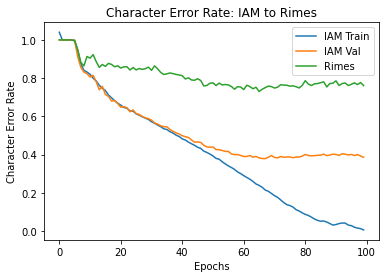

Train: [1.0401590473184223, 1.0, 1.0, 1.0, 0.999806216931217, 0.998764673463111, 0.945977441794997, 0.8747019000208097, 0.8406623856043409, 0.8319799546264136, 0.8203795013224435, 0.7999150135897816, 0.7848920738193911, 0.7625678453449787, 0.7464749001000791, 0.7351007743288703, 0.7117775131163627, 0.6972019252807806, 0.6819153380637465, 0.669244309112227, 0.6589343760067976, 0.6467182349957118, 0.6422326429427484, 0.6286961503648713, 0.6273260451807037, 0.613202109873772, 0.6065204388061199, 0.5977343815610988, 0.5905715764604261, 0.5837549107425656, 0.5718427684075613, 0.5636860963545899, 0.554513898531057, 0.5459472387075714, 0.5350457511308565, 0.5310785916699471, 0.5198420179019395, 0.5127188727260369, 0.5015153292914516, 0.4946358044394761, 0.4819727238322536, 0.47611797093765945, 0.46546720217436643, 0.4568180972258807, 0.44838415167706963, 0.4383253081862167, 0.43234157931887224, 0.4180610872372095, 0.41132491510163244, 0.40272310403985134, 0.39269925549936674, 0.38006496143694

In [0]:
plt.title('Character Error Rate: IAM to Rimes')
plt.xlabel('Epochs')
plt.ylabel('Character Error Rate')
plt.plot(iam_to_rimes_cers[0], label='IAM Train')
plt.plot(iam_to_rimes_cers[1], label='IAM Val')
plt.plot(iam_to_rimes_cers[2], label='Rimes')
plt.legend()
plt.show()
print('Train:', iam_to_rimes_cers[0])
print('Val:', iam_to_rimes_cers[1])
print('Test:', iam_to_rimes_cers[2])

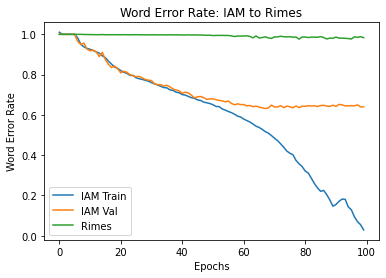

Train: [1.0104166666666667, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9819583333333334, 0.9502083333333333, 0.9379583333333334, 0.9303750000000001, 0.9257916666666667, 0.9196250000000002, 0.9131666666666667, 0.9069583333333334, 0.8930833333333336, 0.884125, 0.8663333333333334, 0.8520416666666667, 0.8376250000000001, 0.8304166666666667, 0.8199583333333335, 0.8120833333333334, 0.8062916666666667, 0.7960000000000002, 0.7962083333333334, 0.7840416666666666, 0.7795000000000001, 0.7760833333333332, 0.7716249999999999, 0.7672916666666666, 0.7601666666666667, 0.7539583333333333, 0.7485833333333334, 0.7419583333333333, 0.7357083333333333, 0.7341666666666665, 0.7241666666666667, 0.7213333333333333, 0.712875, 0.7096666666666666, 0.7009166666666666, 0.6982083333333332, 0.6915, 0.6852916666666666, 0.6818750000000001, 0.6745416666666667, 0.6715833333333333, 0.6633333333333332, 0.6600833333333332, 0.656375, 0.6502083333333333, 0.6420416666666666, 0.6410833333333333, 0.6294583333333333, 0.6235416666666667, 0.61675, 

In [0]:
plt.title('Word Error Rate: IAM to Rimes')
plt.xlabel('Epochs')
plt.ylabel('Word Error Rate')
plt.plot(iam_to_rimes_wers[0], label='IAM Train')
plt.plot(iam_to_rimes_wers[1], label='IAM Val')
plt.plot(iam_to_rimes_wers[2], label='Rimes')
plt.legend()
plt.show()
print('Train:', iam_to_rimes_wers[0])
print('Val:', iam_to_rimes_wers[1])
print('Test:', iam_to_rimes_wers[2])

## Train on the Rimes Dataset, Test on the Iam Dataset

### Train Loop

In [0]:
rimes_dataset = RimesDataset(desired_size=(32, 128), total_imgs=30000)

rimes_train_size = int(.8 * len(rimes_dataset))
rimes_val_size = len(rimes_dataset) - rimes_train_size

rimes_train_dataset, rimes_val_dataset = torch.utils.data.random_split(rimes_dataset, [rimes_train_size, rimes_val_size])

iam_dataset = IamDataset(desired_size=(32, 128), total_imgs=30000)

rimes_to_iam_recognizer, rimes_to_iam_losses, rimes_to_iam_cers, rimes_to_iam_wers = train(rimes_train_dataset, rimes_val_dataset, iam_dataset)

Train - Epoch: 0, Loss: 16.8285, CER: 1.0000, WER: 1.0000, AvgLoss: 30.4208, AvgCER: 1.2084, AvgWER: 1.0107: 100%|██████████| 96/96 [00:31<00:00,  3.07it/s]
Val   - Epoch: 0, Loss: 18.8274, CER: 1.0000, WER: 1.0000, AvgLoss: 18.1716, AvgCER: 1.0000, AvgWER: 1.0000: 100%|██████████| 24/24 [00:05<00:00,  4.54it/s]
Test  - Epoch: 0, Loss: 18.2049, CER: 1.0000, WER: 1.0000, AvgLoss: 17.8603, AvgCER: 1.0000, AvgWER: 1.0000: 100%|██████████| 120/120 [00:24<00:00,  4.90it/s]
Train - Epoch: 1, Loss: 16.6592, CER: 0.9298, WER: 1.0000, AvgLoss: 17.3892, AvgCER: 0.9781, AvgWER: 1.0000: 100%|██████████| 96/96 [00:30<00:00,  3.11it/s]
Val   - Epoch: 1, Loss: 15.9383, CER: 1.0000, WER: 1.0000, AvgLoss: 17.0093, AvgCER: 0.9999, AvgWER: 1.0000: 100%|██████████| 24/24 [00:05<00:00,  4.46it/s]
Test  - Epoch: 1, Loss: 16.9962, CER: 0.9990, WER: 1.0000, AvgLoss: 18.1094, AvgCER: 0.9993, AvgWER: 1.0000: 100%|██████████| 120/120 [00:24<00:00,  4.87it/s]
Train - Epoch: 2, Loss: 17.8804, CER: 1.0000, WER: 1.0

### Results

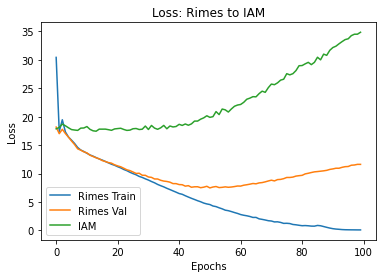

Train: [30.420798937479656, 17.389217754205067, 19.459588527679443, 17.327002217372257, 16.423241247733433, 15.874862680832544, 15.28619239727656, 14.580526570479075, 14.137240966161093, 13.881320168574652, 13.565908869107565, 13.270052015781403, 13.058069626490274, 12.808153480291367, 12.563635498285294, 12.370587488015493, 12.128782361745834, 11.87898787856102, 11.641114691893259, 11.452481577793757, 11.204694559176763, 10.989793638388315, 10.715489765008291, 10.505810489257177, 10.22585109869639, 9.98928133646647, 9.78399113814036, 9.49799088637034, 9.318909168243408, 9.073429842789968, 8.860515197118124, 8.600726306438446, 8.37596740325292, 8.08879184226195, 7.865925704439481, 7.658558666706085, 7.408094048500061, 7.1868923256794615, 6.955196291208267, 6.728188460071881, 6.487294976909955, 6.355518847703934, 6.101044113437335, 5.870999013384183, 5.648304685950279, 5.442437767982483, 5.227690880497296, 5.042979396879673, 4.811105820039908, 4.661197021603584, 4.553656950592995, 4.297

In [0]:
plt.title('Loss: Rimes to IAM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(rimes_to_iam_losses[0], label='Rimes Train')
plt.plot(rimes_to_iam_losses[1], label='Rimes Val')
plt.plot(rimes_to_iam_losses[2], label='IAM')
plt.legend()
plt.show()
print('Train:', rimes_to_iam_losses[0])
print('Val:', rimes_to_iam_losses[1])
print('Test:', rimes_to_iam_losses[2])

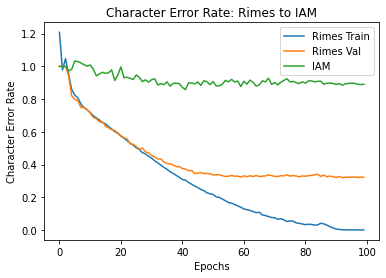

Train: [1.208376519123578, 0.9780860597735598, 1.0472813647001147, 0.9509903014809264, 0.857780333497521, 0.8246861216908092, 0.8078997022143163, 0.769536981700217, 0.7480044879446535, 0.7350660298647432, 0.7187707642167201, 0.6990905938662372, 0.6858380210509806, 0.6725579779867462, 0.6563778359406117, 0.6482202332253802, 0.6322301230972186, 0.6174250090391634, 0.6013956329175998, 0.5903625855421811, 0.5741550935209943, 0.5617867919219941, 0.5453909767350025, 0.5309708859937721, 0.518231209252349, 0.502615570326324, 0.49160525054330195, 0.47279177168487835, 0.46458739687599976, 0.4500225449625266, 0.4391884593313821, 0.42257819745273784, 0.4098722731686886, 0.39708618658710576, 0.38261839313668355, 0.37109343491815916, 0.35679402196387483, 0.3457445296159451, 0.3340934204582182, 0.321969394409376, 0.30872886096746394, 0.3046925277575094, 0.29089292529366056, 0.2801421002336444, 0.2690396536061977, 0.2589703405356898, 0.24807465265195042, 0.24034098457370515, 0.2276236268497298, 0.2211

In [0]:
plt.title('Character Error Rate: Rimes to IAM')
plt.xlabel('Epochs')
plt.ylabel('Character Error Rate')
plt.plot(rimes_to_iam_cers[0], label='Rimes Train')
plt.plot(rimes_to_iam_cers[1], label='Rimes Val')
plt.plot(rimes_to_iam_cers[2], label='IAM')
plt.legend()
plt.show()
print('Train:', rimes_to_iam_cers[0])
print('Val:', rimes_to_iam_cers[1])
print('Test:', rimes_to_iam_cers[2])

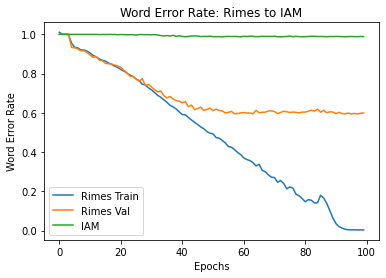

Train: [1.0107083333333333, 1.0, 1.0006666666666666, 0.9978333333333333, 0.9550833333333334, 0.933875, 0.9311250000000001, 0.9204583333333334, 0.9200416666666668, 0.9149583333333334, 0.9056250000000002, 0.8925000000000001, 0.8852500000000001, 0.87475, 0.8682500000000001, 0.8636666666666667, 0.8543750000000001, 0.8466250000000001, 0.8380000000000001, 0.8310416666666667, 0.8207083333333333, 0.812625, 0.8027083333333334, 0.792625, 0.7845416666666667, 0.7724166666666666, 0.7634166666666667, 0.74575, 0.7419583333333334, 0.7272500000000001, 0.7171249999999999, 0.7035, 0.6888333333333332, 0.6795416666666666, 0.6663749999999999, 0.6539166666666666, 0.6383333333333333, 0.6305, 0.62, 0.6049999999999999, 0.5911666666666666, 0.5898333333333333, 0.5760833333333334, 0.5635833333333333, 0.5518333333333333, 0.5405416666666666, 0.5281666666666667, 0.5188333333333334, 0.504625, 0.49629166666666663, 0.49299999999999994, 0.4739583333333333, 0.4708333333333334, 0.4590416666666666, 0.4467083333333333, 0.427

In [0]:
plt.title('Word Error Rate: Rimes to IAM')
plt.xlabel('Epochs')
plt.ylabel('Word Error Rate')
plt.plot(rimes_to_iam_wers[0], label='Rimes Train')
plt.plot(rimes_to_iam_wers[1], label='Rimes Val')
plt.plot(rimes_to_iam_wers[2], label='IAM')
plt.legend()
plt.show()
print('Train:', rimes_to_iam_wers[0])
print('Val:', rimes_to_iam_wers[1])
print('Test:', rimes_to_iam_wers[2])